In [1]:
!pip install -U sentence-transformers scikit-learn umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import torch

In [4]:
df = pd.read_csv('/content/Reviews.csv')
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
38170,38171,B0027UQYZQ,A14XRI4U6BRG8T,Dw,1,1,4,1310774400,Worth the expensive price,I bought this product because I needed freezer...
38171,38172,B0027UQYZQ,AWPT4FH0JR7S1,"Lisa W ""Lisa W""",1,1,5,1300406400,"I love these, price aside",I got these as gifts and absolutely love them....
38172,38173,B0027UQYZQ,AM188RARFCUSA,ks227,1,1,3,1299196800,Gets the job done but not a good value,My parents bought two of these trays as a Chri...
38173,38174,B0027UQYZQ,ACAXV4V8PBCE3,"Texas Rose ""Roseanna""",1,1,5,1297468800,Love it!,I love this product! I have several of these t...


In [5]:
del df['Id']
del df['ProductId']
del df['UserId']
df = df.dropna().reset_index(drop=True)
df

,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...
38167,Dw,1,1,4,1310774400,Worth the expensive price,I bought this product because I needed freezer...
38168,"Lisa W ""Lisa W""",1,1,5,1300406400,"I love these, price aside",I got these as gifts and absolutely love them....
38169,ks227,1,1,3,1299196800,Gets the job done but not a good value,My parents bought two of these trays as a Chri...
38170,"Texas Rose ""Roseanna""",1,1,5,1297468800,Love it!,I love this product! I have several of these t...


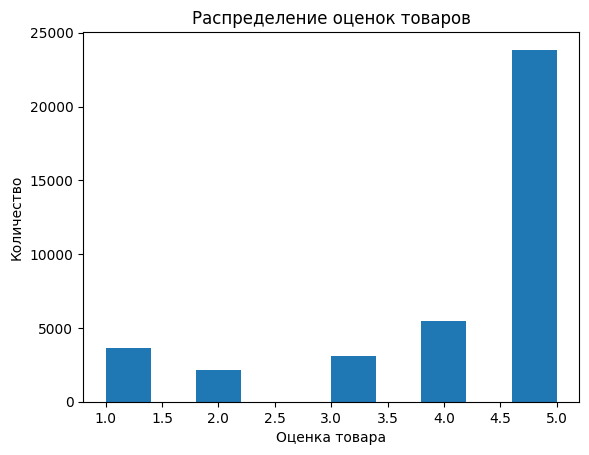

In [6]:
plt.hist(df['Score'])
plt.title("Распределение оценок товаров")
plt.xlabel("Оценка товара")
plt.ylabel("Количество")
plt.show()

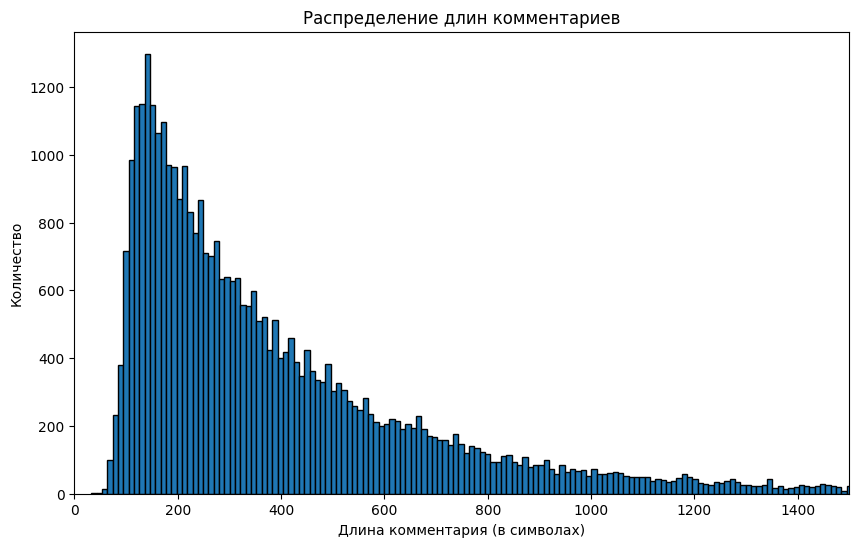

In [7]:
df["text_length"] = df["Text"].astype(str).apply(len)

plt.figure(figsize=(10,6))
plt.hist(df["text_length"], bins=1000, edgecolor="black")
plt.title("Распределение длин комментариев")
plt.xlabel("Длина комментария (в символах)")
plt.ylabel("Количество")
plt.xlim(0, 1500)
plt.show()


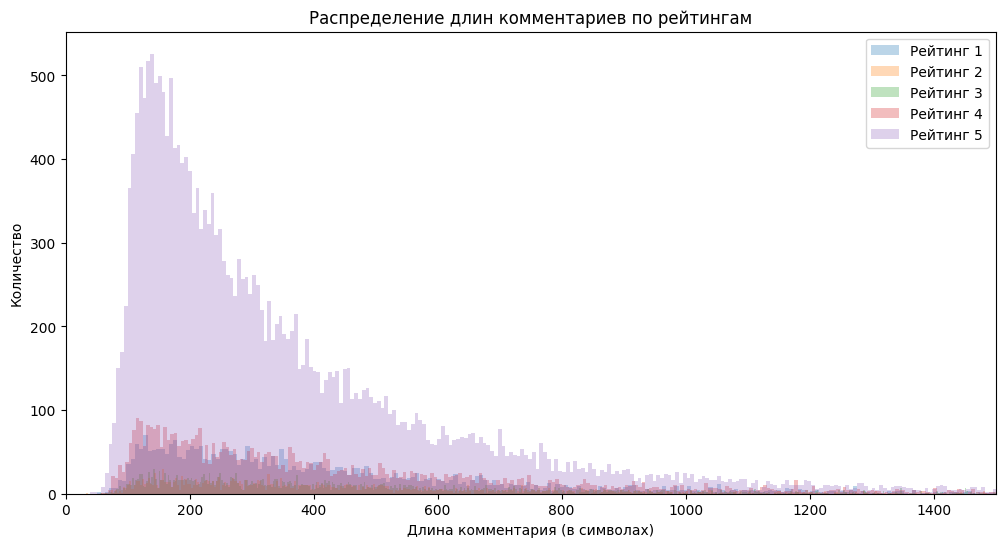

In [8]:
plt.figure(figsize=(12,6))

for rating in range(1, 6):
    subset = df[df["Score"] == rating]
    plt.hist(
        subset["text_length"],
        bins=1500,
        alpha=0.3,
        label=f"Рейтинг {rating}"
    )

plt.title("Распределение длин комментариев по рейтингам")
plt.xlabel("Длина комментария (в символах)")
plt.ylabel("Количество")
plt.legend()
plt.xlim(0, 1500)
plt.show()

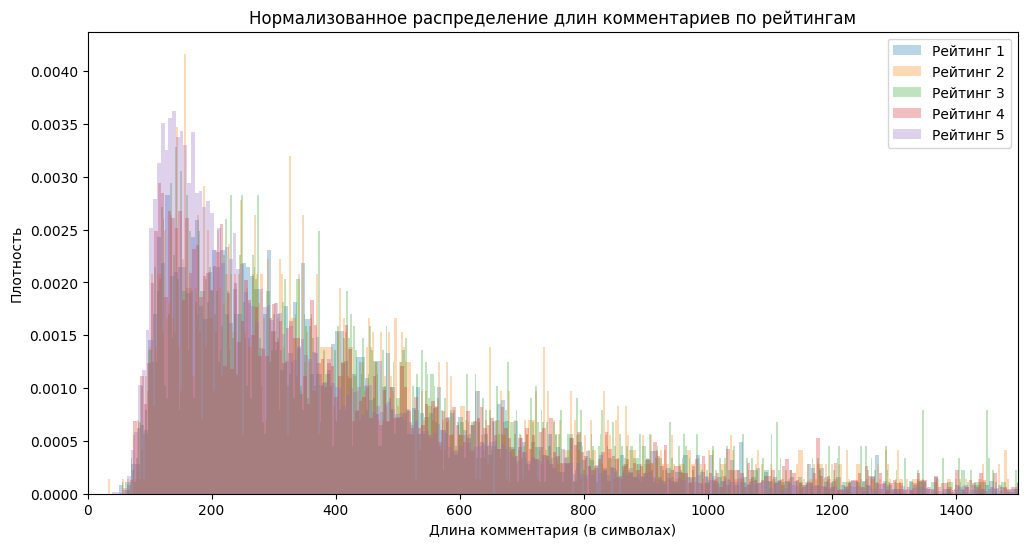

In [9]:
plt.figure(figsize=(12,6))

for rating in range(1, 6):
    subset = df[df["Score"] == rating]
    plt.hist(
        subset["text_length"],
        bins=1500,
        alpha=0.3,
        label=f"Рейтинг {rating}",
        density=True
    )

plt.title("Нормализованное распределение длин комментариев по рейтингам")
plt.xlabel("Длина комментария (в символах)")
plt.ylabel("Плотность")
plt.legend()
plt.xlim(0, 1500)
plt.show()

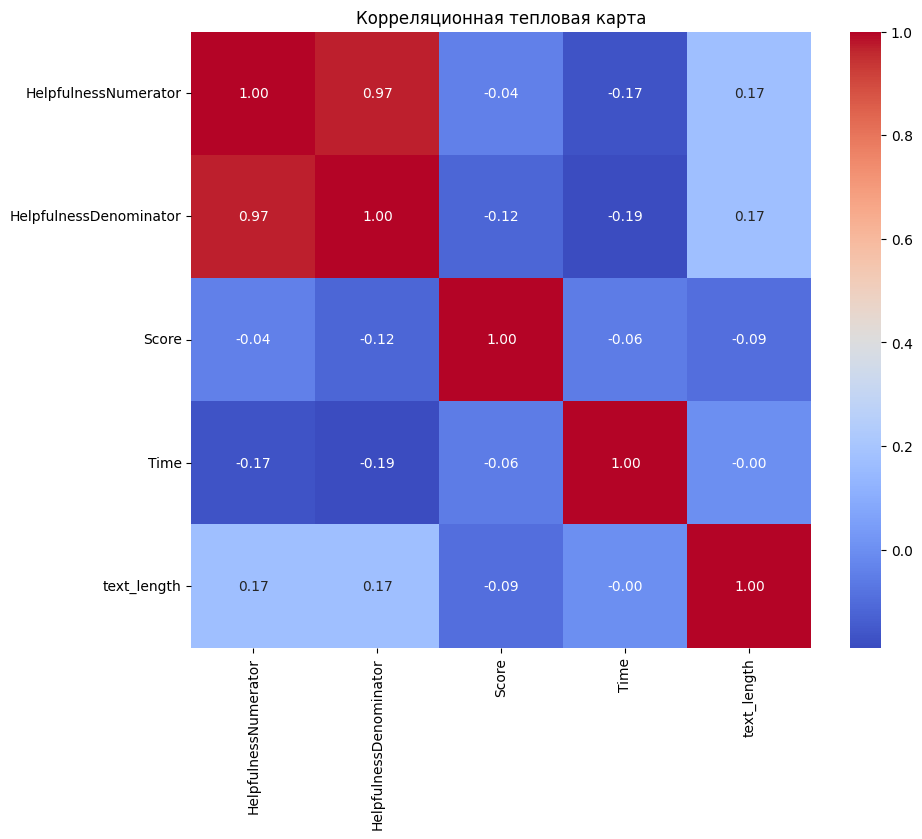

In [10]:
numeric_df = df.select_dtypes(include=["number"])

corr = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная тепловая карта")
plt.show()

Кластеризация комментариев

In [11]:
from sentence_transformers import SentenceTransformer
import torch

# выбираем устройство
device = "cuda" if torch.cuda.is_available() else "cpu"

# загружаем модель на GPU
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

# данные
texts = df["Text"].astype(str).tolist()

# получаем эмбеддинги (они тоже будут на GPU)
embeddings = model.encode(
    texts,
    normalize_embeddings=True,
    show_progress_bar=True,
    device=device   # <--- важно!
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1193 [00:00<?, ?it/s]

In [12]:
import numpy as np

np.save("embeddings.npy", embeddings)   # сохранить
# loaded = np.load("embeddings.npy")      # загрузить обратно

In [13]:
clustering = DBSCAN(eps=0.35, min_samples=5, metric="cosine")
labels = clustering.fit_predict(embeddings)
df["cluster"] = labels

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


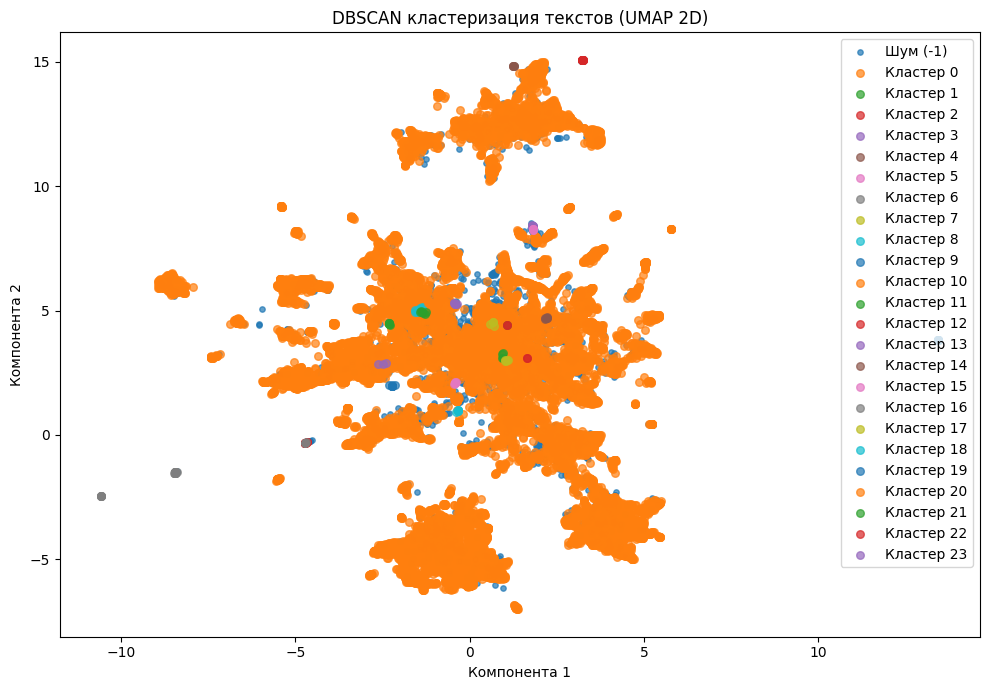

In [14]:
use_umap = False
try:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    coords_2d = reducer.fit_transform(embeddings)
    use_umap = True
except Exception:
    pca = PCA(n_components=2, random_state=42)
    coords_2d = pca.fit_transform(embeddings)

# 4) Визуализация
plt.figure(figsize=(10,7))
unique_labels = np.unique(labels)
for lab in unique_labels:
    mask = labels == lab
    lbl = "Шум (-1)" if lab == -1 else f"Кластер {lab}"
    plt.scatter(coords_2d[mask,0], coords_2d[mask,1], s=30 if lab!=-1 else 15, alpha=0.7, label=lbl)

title_dim = "UMAP" if use_umap else "PCA"
plt.title(f"DBSCAN кластеризация текстов ({title_dim} 2D)")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
print("Размеры кластеров (включая шум -1):")
print(df["cluster"].value_counts().sort_index())

# 6) Примеры текстов по каждому кластеру (по 3 шт.)
for lab in sorted(unique_labels):
    if lab == -1:
        continue
    samples = df[df["cluster"] == lab]["Text"].head(3).tolist()
    print(f"\n=== Кластер {lab} (первые 3 примера) ===")
    for i, t in enumerate(samples, 1):
        print(f"{i}. {t[:200]}{'...' if len(t)>200 else ''}")

Размеры кластеров (включая шум -1):
cluster
-1      4874
 0     33096
 1         4
 2        21
 3         6
 4         5
 5         6
 6        34
 7         4
 8         7
 9        14
 10        5
 11        9
 12       13
 13       19
 14        5
 15        5
 16        9
 17        5
 18        6
 19       10
 20        4
 21        6
 22        2
 23        3
Name: count, dtype: int64

=== Кластер 0 (первые 3 примера) ===
1. I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador...
2. Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.
3. I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a ...

=== Клас